In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as datasets
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import os
from PIL import Image
import random
import numpy as np
import matplotlib

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COVID = 0
PNEU = 1
NORMAL = 2

In [24]:
class CovPneuDataset(datasets.Dataset):
    def __init__(self, covid, pneu, normal, transform):
        self.files = covid + pneu + normal
        self.labels = [COVID]*len(covid) + [PNEU]*len(pneu) + [NORMAL]*len(normal)

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        label = self.labels[idx]

        img = Image.open(file).convert("L")
        img = self.transform(img)
        img = img.repeat(3, 1, 1)

        return img, torch.tensor(label).long()

In [25]:
def tts(x, train_size=0.8):
    files = [os.path.join(x, f) for f in os.listdir(x)]
    random.shuffle(files)
    u = int(train_size * len(files))

    return files[:u], files[u:]

In [26]:
epochs = 10
lr = 1e-4
batch_size = 32
test_batch_size = 16


In [27]:
class HistEQ(object):
    def __call__(self, img):
        return torchvision.transforms.functional.equalize(img)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(8, translate=(0.04, 0.04), scale=(0.8, 1.2), shear=0.2),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomHorizontalFlip(0.3),
    HistEQ(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    HistEQ(),
    transforms.ToTensor(),
])

In [28]:
random.seed(42)
covid_train, covid_test = tts("covid")
pneu_train, pneu_test = tts("pneumonia")
normal_train, normal_test = tts("normal")

train_data = CovPneuDataset(covid_train, pneu_train, normal_train, train_transform)
test_data = CovPneuDataset(covid_test, pneu_test, normal_test, test_transform)

train_loader = datasets.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = datasets.DataLoader(test_data, batch_size=test_batch_size)

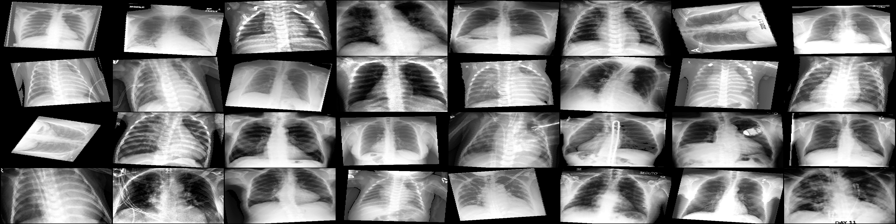

In [273]:
to_pil = transforms.ToPILImage()
ex_images = next(iter(train_loader))[0]

grid_images = torchvision.utils.make_grid(ex_images, nrow=8)
pil_image = to_pil(grid_images).resize((224*4, 224))

display(pil_image)

In [264]:
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.fc.in_features, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3)
).to(device)


optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
get_acc = lambda preds, y: get_valid(preds, y, binary=False)


C:\Users\dassu\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\dassu\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
def get_valid(preds, y, binary=True):
    if binary:
        return torch.eq(torch.round(preds), y).int().sum().item()

    return torch.eq(torch.argmax(preds, dim=1), y).int().sum().item()


In [31]:
best_model_idx = 0
best_acc = -1

In [32]:
for epoch in range(epochs):
    losses = []

    valid = 0
    total = 0

    model.train()
    for i, (img, label) in enumerate(train_loader):
        optimizer.zero_grad()
        y = model(img.to(device))
        loss = criterion(y, label.to(device))

        loss.backward()
        optimizer.step()

        preds = torch.softmax(y.cpu(), 1)

        losses.append(loss.item())
        valid += get_acc(preds, label)
        total += img.shape[0]

        print("\r", f"train epoch {epoch}/{epochs}, iter {i}/{len(train_loader)}, avg_loss {sum(losses) / len(losses)}, acc {valid / total}", end="")
    print("")
    losses = []

    valid = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            y = model(img.to(device))
            loss = criterion(y, label.to(device))

            losses.append(loss.item())
            preds = torch.softmax(y.cpu(), 1)

            valid += get_acc(preds, label)
            total += img.shape[0]

            print("\r", f"test epoch {epoch}/{epochs}, iter {i}/{len(test_loader)}, avg_loss {sum(losses) / len(losses)}, acc {valid / total}", end="")

    acc = valid/total
    if acc > best_acc:
        best_acc = acc
        best_model_idx = epoch
        print("EPOCH", epoch, "HAS BEST MODEL ACC", acc)
    print("")
    torch.save(model, f"models/model_{epoch}.pth")

 train epoch 0/10, iter 173/174, avg_loss 0.31506129085546597, acc 0.8913513513513514
 test epoch 0/10, iter 86/87, avg_loss 0.18663009958496937, acc 0.9409647228221742EPOCH 0 HAS BEST MODEL ACC 0.9409647228221742

 train epoch 1/10, iter 173/174, avg_loss 0.19751911715272513, acc 0.9354954954954955
 test epoch 1/10, iter 86/87, avg_loss 0.15483483899486433, acc 0.9496040316774658EPOCH 1 HAS BEST MODEL ACC 0.9496040316774658

 train epoch 2/10, iter 173/174, avg_loss 0.17596275855027055, acc 0.9409009009009015
 test epoch 2/10, iter 86/87, avg_loss 0.14635016491513528, acc 0.9524838012958964EPOCH 2 HAS BEST MODEL ACC 0.9524838012958964

 train epoch 3/10, iter 173/174, avg_loss 0.1552703755789961, acc 0.94972972972972973
 test epoch 3/10, iter 86/87, avg_loss 0.13331346213282352, acc 0.9611231101511879EPOCH 3 HAS BEST MODEL ACC 0.9611231101511879

 train epoch 4/10, iter 173/174, avg_loss 0.1415557255112063, acc 0.95369369369369377
 test epoch 4/10, iter 86/87, avg_loss 0.1462637891197

In [104]:
best_model = torch.load(f"models/model_{best_model_idx}.pth")

In [34]:
import torchmetrics as metrics

best_model.eval()

confusion_matrix = metrics.ConfusionMatrix(num_classes=3)
auc_covid = metrics.AUROC(num_classes=1)
auc_pneumonia = metrics.AUROC(num_classes=1)
auc_normal = metrics.AUROC(num_classes=1)

def update_auc(auc, pred, label, target_class):
    auc_labels = torch.zeros_like(label)
    auc_labels[label == target_class] = 1

    auc.update(pred[:, target_class], auc_labels)

with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        y = best_model(img.to(device))
        preds = torch.softmax(y.cpu(), 1)

        update_auc(auc_pneumonia, preds, label, PNEU)
        update_auc(auc_covid, preds, label, COVID)
        update_auc(auc_normal, preds, label, NORMAL)

        confusion_matrix.update(preds, label.long())

C:\Users\dassu\AppData\Local\Programs\Python\Python39\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [35]:
auc_pneumonia.compute(), auc_covid.compute(), auc_normal.compute()

(tensor(0.9901), tensor(0.9983), tensor(0.9871))

In [36]:
confusion_matrix.compute()

tensor([[452,   0,  11],
        [  1, 425,  37],
        [  3,   2, 458]])

<AxesSubplot:>

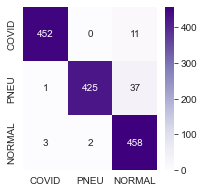

In [37]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = np.array(confusion_matrix.compute()).tolist()
df_cm = pd.DataFrame(array, index = ["COVID", "PNEU", "NORMAL"],
                  columns = ["COVID", "PNEU", "NORMAL"])
plt.figure(figsize = (3,3))
sn.heatmap(df_cm, annot=True,cmap='Purples', fmt='g')

In [38]:
COVID, PNEU, NORMAL

(0, 1, 2)

In [235]:
class GradCamTracker(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.gradients = None
        self.forward_out = None

        torch.save(model, "temp_model.pth")
        self.model = torch.load("temp_model.pth")
        self.model.layer4.register_forward_hook(self.forward_hook())

    def grad_hook(self,grad):
        self.gradients = grad

    def forward_hook(self):
        def hook(module, inputs, outputs):
            self.forward_out = outputs
            outputs.register_hook(self.grad_hook)
        return hook

    def forward(self,x):
        out = self.model(x)
        return out, self.forward_out

In [236]:
grad_cam = GradCamTracker(best_model).to(device)

In [237]:
ex_img, ex_label = test_data[random.randint(0, len(test_data))]
grad_cam(ex_img.to(device).unsqueeze(0))

(tensor([[ 3.6402, -2.8929, -0.3264]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0649, 0.0236, 0.0000,  ..., 0.0000, 0.1073, 0.1647],
           [0.4390, 0.3738, 0.1116,  ..., 0.0000, 0.1379, 0.4019],
           ...,
           [0.3111, 1.0370, 0.9500,  ..., 0.1226, 0.0000, 0.0000],
           [0.3410, 1.9158, 1.4649,  ..., 0.1094, 0.0000, 0.0000],
           [0.3405, 1.2811, 0.8252,  ..., 0.1177, 0.0000, 0.0000]],
 
          [[0.7526, 0.6194, 0.2180,  ..., 0.2529, 1.5782, 1.7076],
           [3.1165, 2.9152, 1.2318,  ..., 0.6384, 2.4167, 2.9606],
           [1.9002, 1.8141, 1.0739,  ..., 0.8701, 1.2458, 1.2922],
           ...,
           [0.3290, 1.1132, 1.5121,  ..., 1.3154, 0.5289, 0.4370],
           [0.6505, 1.4991, 1.4667,  ..., 0.3518, 0.5476, 0.3678],
           [0.5562, 1.3620, 1.2766,  ..., 0.1634, 0.6270, 0.0677]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0923, 0.1422, 0.0000],


In [284]:
from skimage.transform import resize

def get_grad_cam(img, label):
    out, feature_layer = grad_cam(img)
    feature_layer = feature_layer.cpu()
    crit = nn.CrossEntropyLoss()

    target = torch.tensor([label]).to(device).long()
    loss = crit(out, target)
    loss.backward()

    grads = grad_cam.gradients.detach().cpu()
    pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

    feature_layer += pooled_grads.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

    heatmap = torch.mean(feature_layer, dim = 1).cpu().squeeze()
    heatmap /= heatmap.max(axis = 0)[0]

    heatmap_j = resize(heatmap.detach().numpy(),(224,224),preserve_range=True)

    cmap = matplotlib.cm.get_cmap("jet",256)
    heatmap_j2 = cmap(heatmap_j,alpha = 0.2)
    return heatmap_j2

(224, 224, 4)


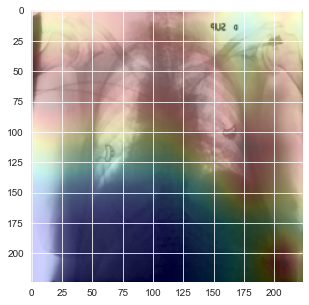

COVID


In [286]:
ex_img, ex_label = test_data[random.randint(0, len(test_data))]

fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(1-np.rot90(ex_img.transpose(0, 2), k=-1))
axs.imshow(get_grad_cam(ex_img.to(device).unsqueeze(0), ex_label.item()))
plt.show()
print(["COVID", "PNEUMONIA", "NORMAL"][ex_label.item()])